### 1. 라이브러리 불러오기

일반 CPU 활용 시

In [2]:
# 라이브러리 정의 
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

cuda nvidia gpu 활용 시

In [4]:
# How to check if the code is running on GPU or CPU?

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11887219552399883596
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1443813785
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16723502886646983198
physical_device_desc: "device: 0, name: GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


intel gpu 활용 시

In [3]:
# import numpy as np
# import os

# # intel gpu 적용
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
# import keras
# # mnist 데이터셋 
# from keras.datasets import mnist


In [4]:
import warnings
warnings.filterwarnings(action="ignore")

In [5]:
import pandas as pd
import numpy as np
import cv2
import os
from datetime import datetime

# from tensorflow import keras
from tensorflow import keras
# One-Hot Encoding, Model Plot
from tensorflow.keras.utils import to_categorical, plot_model
# Add Model
from tensorflow.keras import Sequential
# Add Model Layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
# Model Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Split Data to Train-Test
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### 2. 데이터 불러오기 및 분리

In [6]:
pwd

'C:\\Users\\kopo\\poly_demo\\Session35 - Service Project-CV'

In [7]:
"../images/emo"

'../images/emo'

In [8]:
basedir = "../images/emotion_s/input/train/"

imageList = []
labelList = []

IMG_SIZE = 48

In [9]:
categories = os.listdir(basedir)
print(categories)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
# 분류 폴더 순환
for i in range(len(categories)):
    labelPath = os.path.join(basedir, categories[i])
    labelPath

    imagePath = os.listdir(labelPath)
    # 폴더별 이미지 순환
    for j in range(len(imagePath)):
        imageFullPath = os.path.join(labelPath, imagePath[j])
        try:
            _img = cv2.imread(imageFullPath, cv2.IMREAD_GRAYSCALE)

            #### 2-1. 이미지 사이즈 변경
            resizedImg = cv2.resize(_img, (IMG_SIZE, IMG_SIZE))
            
            imageList.append(resizedImg)
            labelList.append(i)
        except Exception as e:
            print(e, imageFullPath)
            pass

In [11]:
# 데이터 전치리를 편리하게 하기 위해 형변환 List > Array
imageArray = np.array(imageList)
labelArray = np.array(labelList)

print (imageArray.shape, labelArray.shape)

(114826, 48, 48) (114826,)


In [12]:
# trainData와 testData로 분리
trainData_features,\
testData_features,\
trainData_labels,\
testData_labels = \
    train_test_split(imageArray, labelArray, test_size=0.2, random_state=2)

print(trainData_features.shape, testData_features.shape)
print(trainData_labels.shape, testData_labels.shape)

(91860, 48, 48) (22966, 48, 48)
(91860,) (22966,)


In [13]:
# CNN 사용을 위해 features 구조 변경
trainData_features = \
    trainData_features.reshape(len(trainData_features), IMG_SIZE, IMG_SIZE, 1)
testData_features = \
    testData_features.reshape(len(testData_features), IMG_SIZE, IMG_SIZE, 1)

print(trainData_features.shape, testData_features.shape)

(91860, 48, 48, 1) (22966, 48, 48, 1)


In [14]:
# feature 정규화
trainData_features_norm = trainData_features/255.0
testData_features_norm = testData_features/255.0

print(trainData_features_norm.shape, testData_features_norm.shape)

(91860, 48, 48, 1) (22966, 48, 48, 1)


In [15]:
# softmax와 결합을 위한 label one-hot encoding
trainData_labels_one = to_categorical(trainData_labels)
testData_labels_one = to_categorical(testData_labels)

print(trainData_labels_one.shape, testData_labels_one.shape)

(91860, 7) (22966, 7)


### 3. 모델 생성

In [16]:
inputShape = trainData_features[0].shape
inputShape

(48, 48, 1)

In [17]:
outputShape = len(categories)
outputShape

7

In [18]:
# 모델 초기화
model = Sequential()

In [19]:
# 모델 정의
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding="same",
                 activation="relu",
                 input_shape=inputShape)) # 초기 레이어 선언

model.add(MaxPool2D(pool_size=2))

model.add(Dropout(0.4)) # 사용할 비율 명시

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding="same",
                 activation="relu"))

model.add(MaxPool2D(pool_size=2))

model.add(Flatten())

model.add(Dense(units=outputShape,
                activation="softmax"))

In [20]:
# 모델 Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 6

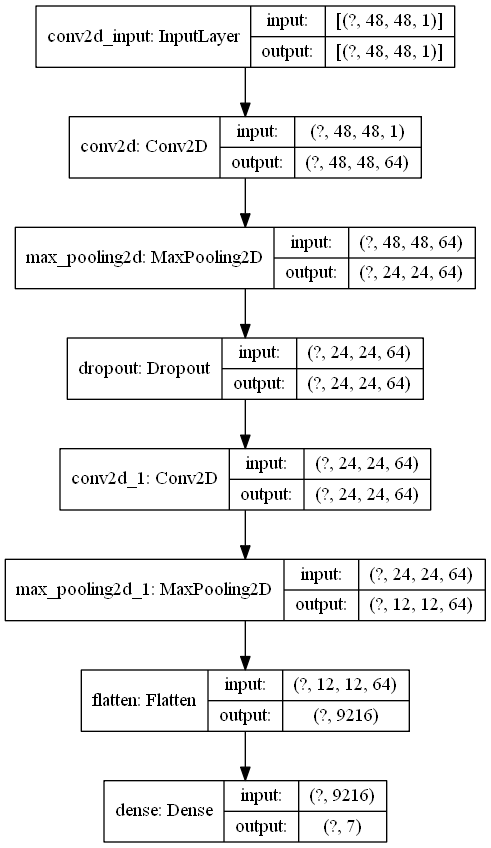

In [21]:
plot_model(model, show_shapes=True)

### 4. 모델 컴파일

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### 5. 모델 학습(훈련) 

In [23]:
epochNo = 5

In [24]:
now = datetime.now()
logdt = now.strftime("%Y%m%d_%H%M%S")
logdate = os.path.join("log_mnist",logdt)

In [25]:
callback_list = [
    EarlyStopping(monitor="val_loss",patience=10),
    ModelCheckpoint(filepath="./emo_weight2.h5",monitor="val_loss",save_best_only=True, verbose=1),
    TensorBoard(log_dir=logdate, write_graph=True, write_images=True)
]

In [26]:
model.fit(x=trainData_features_norm,
          y=trainData_labels_one,
          epochs=epochNo,
          batch_size=32,
          validation_data=(testData_features_norm, testData_labels_one))

Epoch 1/5
2871/2871 [==============================] - 58s 20ms/step - loss: 1.4360 - accuracy: 0.4519 - val_loss: 1.2306 - val_accuracy: 0.5386
Epoch 2/5
2871/2871 [==============================] - 62s 22ms/step - loss: 1.1701 - accuracy: 0.5650 - val_loss: 1.1081 - val_accuracy: 0.5981
Epoch 3/5
2871/2871 [==============================] - 70s 24ms/step - loss: 1.0387 - accuracy: 0.6185 - val_loss: 1.0013 - val_accuracy: 0.6373
Epoch 4/5
2871/2871 [==============================] - 106s 37ms/step - loss: 0.9435 - accuracy: 0.6552 - val_loss: 0.9407 - val_accuracy: 0.6660
Epoch 5/5
2871/2871 [==============================] - 64s 22ms/step - loss: 0.8769 - accuracy: 0.6780 - val_loss: 0.8658 - val_accuracy: 0.6895


### 6. 모델 추론

In [27]:
model.evaluate(x=testData_features_norm,
               y=testData_labels_one)

718/718 [==============================] - 13s 18ms/step - loss: 0.8658 - accuracy: 0.6895


[0.865817666053772, 0.6894975304603577]

### 7. 모델 예측

In [28]:
def refineImage(testImg):
    # Color to Gray
    greyImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2GRAY)
    # greyImg.shape

    # Image Resize
    resizeImg = cv2.resize(greyImg, (IMG_SIZE, IMG_SIZE))
    # resizeImg.shape

    # Image Reshape
    predictImg = resizeImg.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    # predictImg.shape

    ## Image Normalization
    predictImg_norm = predictImg/255.0
    
    return predictImg_norm

In [29]:
_img = cv2.imread("./sample_emotion.jpg", cv2.IMREAD_COLOR)
testImg = refineImage(_img)
testImg.shape

(1, 48, 48, 1)

In [30]:
categories[np.argmax(model.predict(testImg))]

'happy'

### 8. 모델 저장

In [31]:
# 모델의 구조 저장
model_json = model.to_json()
with open("./model_emotion.json", "w") as json_file:
    json_file.write(model_json)

In [32]:
# 모델 학습내용 저장
model.save_weights("./model_emotion_weight.h5")

# GPU 메모리 릴리즈

In [33]:
from tensorflow.keras import backend as K

K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()